In [85]:
import numpy as np 
import matplotlib.pyplot as plt
from scipy.integrate import solve_ivp, solve_bvp

## Startup-Flow - Power Law Fluid

The numerics of non-Newtonian flow are very similar for the power law as Newtonian flow, it's the maths that's that's the hard part, which is explained in my thesis, linked in the READ_ME of this repo. The short version is that we replace the stress tensor $\tau$ with the power law: $\tau = \hat{\mu}|\dot{\gamma}|^{\frac{1}{n}}\dot{\gamma}$ and inject this into the equation for the pressure, take the derivative and go from there. 

We use the same finite volume method, only altering the function outlining the content of the RHS which now contains a lot of n's. We solve the equation 
$$
h_t = -\frac{\partial}{\partial x}\left(h^{\frac{2n+1}{n}}sgn(h_{xxx})\left|h_{xxx}\right|^{\frac{1}{n}}\right) + h_x
$$ 

We test this equation by setting n to 1 which we can do both analytically and numerically. The latter will be done in this jupyter notebook. <br> As stated, the only function that is altered for non-Newtonian startup flow is the function for the RHS so let's define some initial variables and write it...

In [120]:
N = 100                         # Number of points to evaluate
L = 10                          # Length of surface
dx = L/N                        # Change in x
n = 0.80                        # Defining the power law

h_0 = 1.0                       # Initial film height
Q = 0.8                         # Flux entering the system

x = np.linspace(0, L, N)        # Array for plotting
h_initial = np.ones(N) * h_0    # Initial guess for the solver

t_span = (0, 100)               # The time at which this process should be evaluated from and to

In [109]:
def make_step(h, i, n, print_except=False):
    """
    (Try, except)'s are for the BCs, as q_minus won't be computable for BCs at the start and q_plus won't be computable
    for BCs at the end.
    The bool 'print_except' is for making sure anything inside the for loop is not displaying a 0.
    """

    DX = 1/dx**3
    epsilon = 0

    try:
        non_linear_h = (0.5 * (h[i] + h[i+1]))**((2*n + 1)/n) + epsilon
        third_order = abs(-h[i-1] + 3*h[i] - 3*h[i+1] + h[i+2] + epsilon) ** (1 / n)
        third_order_sign = np.sign(-h[i-1] + 3*h[i] - 3*h[i+1] + h[i+2])
        advection_term = h[i]

        q_plus = DX  * non_linear_h * third_order_sign * third_order + advection_term

    except IndexError:
        q_plus = 0
        if print_except: print("Q plus is 0!")

    try:
        non_linear_h = (0.5 * (h[i] + h[i-1])) ** ((2*n+1)/n) + epsilon
        third_order = abs(-h[i-2] + 3*h[i-1] - 3*h[i] + h[i+1] + epsilon) ** (1 / n)
        third_order_sign = np.sign(-h[i-2] + 3*h[i-1] - 3*h[i] + h[i+1])
        advection_term = h[i-1]

        q_minus = DX * non_linear_h * third_order_sign * third_order + advection_term

    except IndexError:
        q_minus = 0
        if print_except: print("Q minus is 0!")

    return q_plus, q_minus

Next we define the function that we put into the solver which is the same as the one we used for the Newtonian solve.

In [110]:
def FVM(t, h, Q=Q, n=n):
    h = h.copy()
    dhdt = np.zeros_like(h)

    # i = 0
    h[0] = h_0

    # i = 1
    q_plus, q_minus = make_step(h=h, i=1, n=n)
    dhdt[1] = - (q_plus - Q) / dx

    # i = N - 2
    q_plus, q_minus = make_step(h=h, i=N-2, n=n)
    dhdt[N-2] = - (h[N-2] - q_minus) / dx

    # i = N - 1
    h[N-1] = h[N-2]
    dhdt[N-1] = dhdt[N-2]

    for i in range(2, N-2):
        q_plus, q_minus = make_step(h, i, n, print_except=True)
        dhdt[i] = -(q_plus - q_minus) / dx

    return dhdt

We then solve the system!

In [96]:
sol = solve_ivp(fun=FVM, y0=h_initial, t_span=t_span, method='BDF', rtol=1e-6, atol=1e-8)

print(sol.status)
print(sol.success)
print(sol.message)

0
True
The solver successfully reached the end of the integration interval.


And plot a simple graph

Text(0.5, 0, 'Length $(x)$')

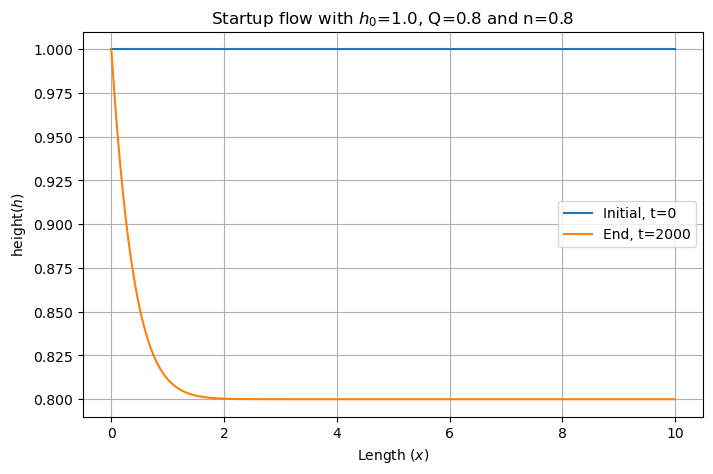

In [97]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(8, 5))

ax.plot(x, sol.y[:, 0], label=f'Initial, t={t_span[0]}')
ax.plot(x, sol.y[:, -1], label=f'End, t={t_span[1]}')
ax.grid(True)
ax.legend()
ax.set_title(f"Startup flow with $h_0$={h_0}, Q={Q} and n={n}")
ax.set_ylabel('height$(h)$')
ax.set_xlabel('Length $(x)$')

We need to confirm that setting n=1 gives the same result as the Newtonian steady state flow:

In [121]:
# Define Functions
def ODE(x, y):
    """
    Split ODE into three first order ODEs, returns the derivative of the vector y linking the ODEs.
    """
    dy_3 = (Q-y[0])/(y[0]**3)

    return np.array([y[1], y[2], dy_3])

def bc(x_zero, x_L):
    """
    Boundary conditions for the BVP to show the height at each boundary and flux at x=0.
    """
    return np.array([x_zero[0]-1, x_L[1], x_L[0]-Q])

def solver():
    """
    Uses scipy integrate to solve the boundary value problem
    """
    x = np.linspace(0, L, N)
    y = np.zeros((3, x.size))
    y[0] = h_0
    solution = solve_bvp(ODE, bc, x, y)
    return solution

newt_sol = solver()
non_newt_sol = solve_ivp(fun=FVM, y0=h_initial, t_span=t_span, method='BDF', rtol=1e-6, atol=1e-8, args=(Q, 1))

print(sol.status)
print(sol.success)
print(sol.message)

0
True
The solver successfully reached the end of the integration interval.


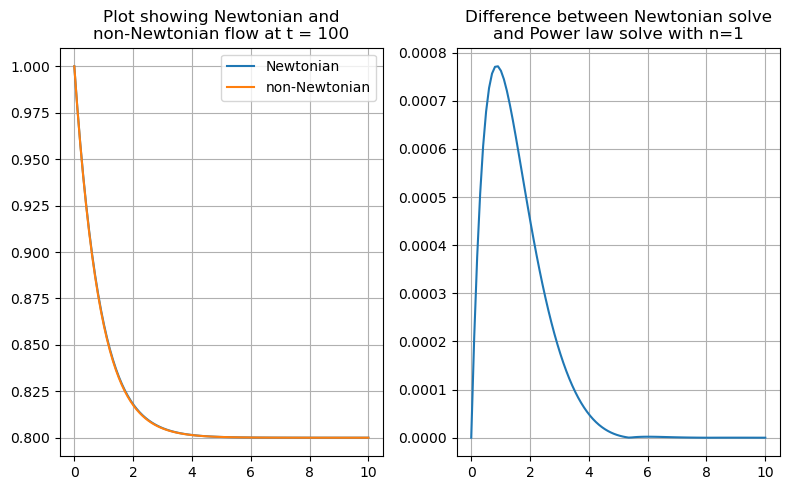

In [122]:
difference = abs(newt_sol.y[0, :] - non_newt_sol.y[:, -1])

fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(8, 5))
ax[0].plot(newt_sol.x, newt_sol.y[0, :], label="Newtonian")
ax[0].plot(x, non_newt_sol.y[:, -1], label="non-Newtonian")
ax[0].grid(True)
ax[0].legend()
ax[0].set_title(f"Plot showing Newtonian and\nnon-Newtonian flow at t = {t_span[1]}")

ax[1].plot(x, difference)
ax[1].set_title(f"Difference between Newtonian solve\nand Power law solve with n=1")
ax[1].grid(True)

fig.tight_layout()

Plot a fancier graph, warning, this block of code takes about 15 mins to run on my macbook air (2020)

In [41]:
ns = [0.25, 0.5, 0.75, 1, 1.25, 1.5]                # Defining the power law
Qs = [0.1, 0.25, 0.5, 0.75, 0.8, 0.9, 0.95]         # Flux entering the system

solves = []
for n in ns:
    print(f"\nCurrently solving for n = {n}:")
    solve = []
    for Q in Qs:
        print(f"    Q = {Q},")
        sol = solve_ivp(fun=FVM, y0=h_initial, t_span=t_span, method='BDF', rtol=1e-6, atol=1e-8, args=(Q, n))
        if sol.status != 0:
            print(f"Error! Solver failed on n={n}, Q={Q}")
        else:
            solve.append(sol.y[:, -1])
    solves.append(solve)


Currently solving for n = 0.25:
    Q = 0.1,
    Q = 0.25,
    Q = 0.5,
    Q = 0.75,
    Q = 0.8,
    Q = 0.9,
    Q = 0.95,

Currently solving for n = 0.5:
    Q = 0.1,
    Q = 0.25,
    Q = 0.5,
    Q = 0.75,
    Q = 0.8,
    Q = 0.9,
    Q = 0.95,

Currently solving for n = 0.75:
    Q = 0.1,
    Q = 0.25,
    Q = 0.5,
    Q = 0.75,
    Q = 0.8,
    Q = 0.9,
    Q = 0.95,

Currently solving for n = 1:
    Q = 0.1,
    Q = 0.25,
    Q = 0.5,
    Q = 0.75,
    Q = 0.8,
    Q = 0.9,
    Q = 0.95,

Currently solving for n = 1.25:
    Q = 0.1,
    Q = 0.25,
    Q = 0.5,
    Q = 0.75,
    Q = 0.8,
    Q = 0.9,
    Q = 0.95,

Currently solving for n = 1.5:
    Q = 0.1,
    Q = 0.25,
    Q = 0.5,
    Q = 0.75,
    Q = 0.8,
    Q = 0.9,
    Q = 0.95,


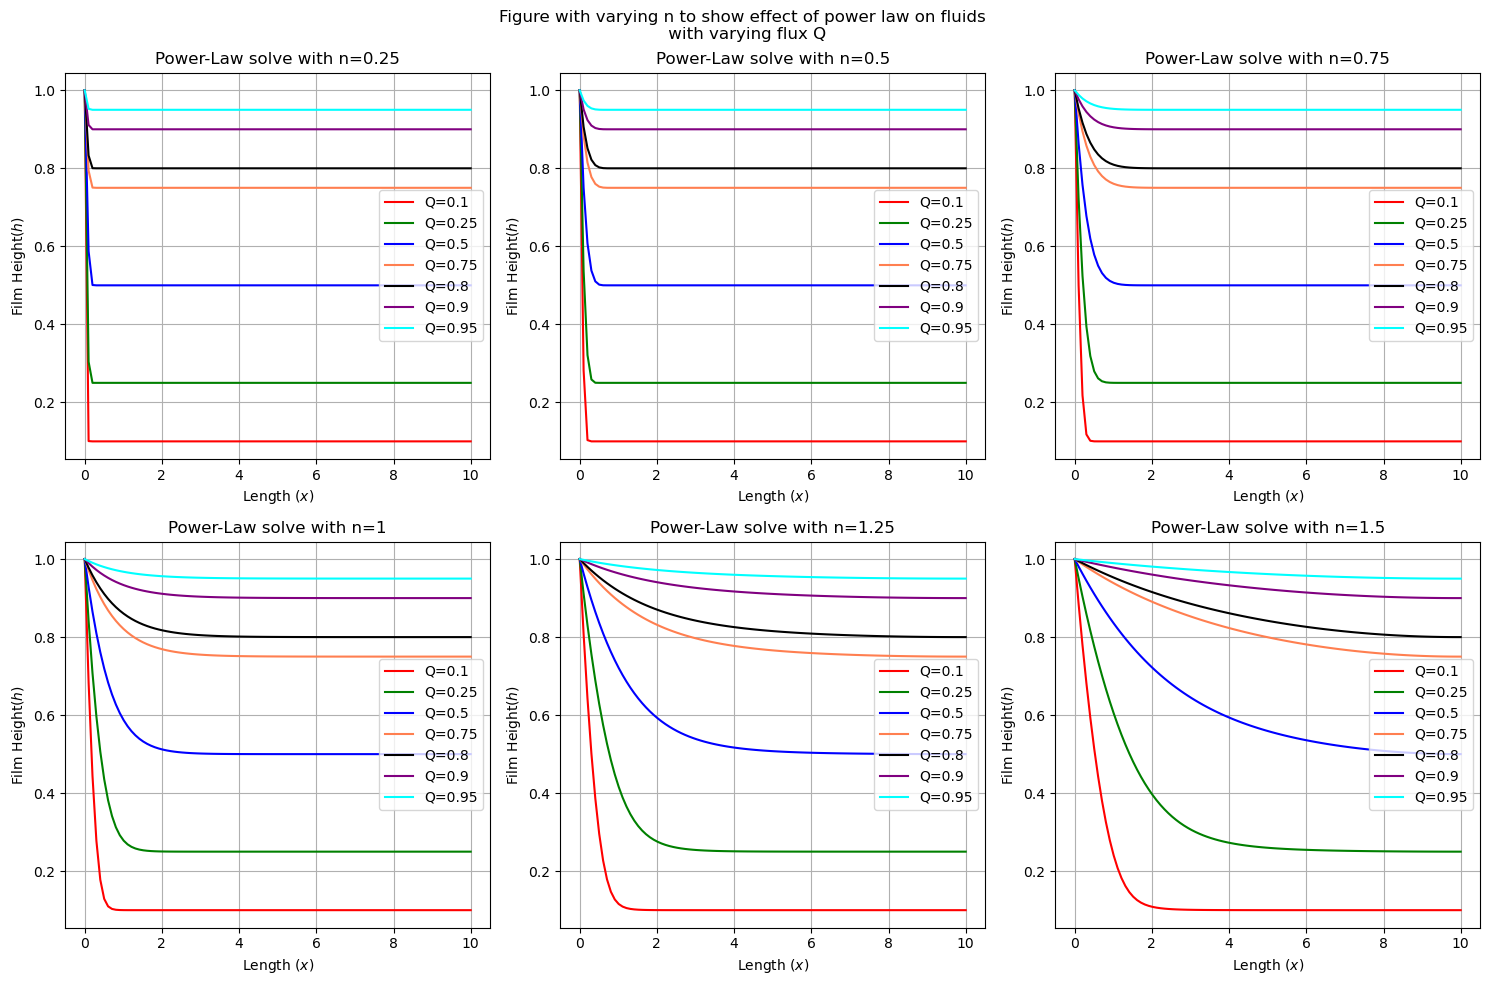

In [123]:
rows = 2
cols = 3

fig, ax = plt.subplots(nrows=rows, ncols=cols, figsize=(15, 10))
colors = ['red', 'green', 'blue', 'coral', 'black', 'purple', 'cyan']
j = 0
for row in range(rows):
    for col in range(cols):
        [ax[row, col].plot(x, solves[j][i], label=f"Q={Qs[i]}", color=colors[i]) for i in range(len(Qs))]
        ax[row, col].legend()
        ax[row, col].set_title(f"Power-Law solve with n={ns[j]}")
        ax[row, col].grid(True)
        ax[row, col].set_xlabel('Length $(x)$')
        ax[row, col].set_ylabel('Film Height$(h)$')
        j += 1
        
fig.suptitle("Figure with varying n to show effect of power law on fluids \n with varying flux Q")
fig.tight_layout()